AI Final Project
=============

[Dataset](https://www.kaggle.com/fedesoriano/heart-failure-prediction?select=heart.csv) from Kaggle

In [5]:
import os
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import matplotlib.pyplot as plt
import random


from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

from scipy.special import erfinv

import lightgbm as lgb

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import optuna
from optuna.trial import TrialState

from pytorch_lightning import Trainer, LightningDataModule, LightningModule
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import pytorch_lightning as pl



from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, auc, roc_curve, accuracy_score



In [6]:
RANDOM_SEED = 42
BATCH_SIZE = 16
LR = 1e-3
DEVICE = 'cuda' if torch.cuda.is_available else 'cpu'


In [7]:
def setup_seed(seed):
    random.seed(seed)                          
    np.random.seed(seed)                       
    torch.manual_seed(seed)                    
    torch.cuda.manual_seed(seed)               
    torch.cuda.manual_seed_all(seed)           
    torch.backends.cudnn.deterministic = True  


setup_seed(RANDOM_SEED)

# Exploratory Data Analysis
-------------

## Data Features

We can separate data features into numeric features, categorical features and the target for our task

### Numeric Features :

* Age: age of the patient [years]
* RestingBP: resting blood pressure [mm Hg]
* Cholesterol: serum cholesterol [mm/dl]
* MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
* Oldpeak: oldpeak = ST [Numeric value measured in depression]

### Categorical Features :


* Sex: sex of the patient [M: Male, F: Female]
* ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
* FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
* RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
* ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
* ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]

### Target :

* HeartDisease: output class [1: heart disease, 0: Normal]


## Dataset

In [8]:
df = pd.read_csv("Dataset/heart.csv")

### Missing Values

In [9]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [10]:
df.describe()

Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   
mean    53.510893  132.396514   198.799564    0.233115  136.809368   
std      9.432617   18.514154   109.384145    0.423046   25.460334   
min     28.000000    0.000000     0.000000    0.000000   60.000000   
25%     47.000000  120.000000   173.250000    0.000000  120.000000   
50%     54.000000  130.000000   223.000000    0.000000  138.000000   
75%     60.000000  140.000000   267.000000    0.000000  156.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  HeartDisease  
count  918.000000    918.000000  
mean     0.887364      0.553377  
std      1.066570      0.497414  
min     -2.600000      0.000000  
25%      0.000000      0.000000  
50%      0.600000      1.000000  
75%      1.500000      1.000000  
max      6.200000      1.000000

First, let's take a glimpse of the dataset. It shows that there is no null value in the dataset.

However, we find that the minimum values of `RestingBP` and `Cholesterol` are 0, which is not normal.

We assume that they are missing the values filled with 0s incorrectly.



In [11]:
df[df['RestingBP'] == 0]

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
449   55   M           NAP          0            0          0     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
449    155              N      1.5     Flat             1

There is only 1 row missing value at `RestingBP`. We can simply remove this row.

In [12]:
df = df[df['RestingBP'] > 0]

In [13]:
df[df['Cholesterol'] == 0]

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
293   65   M           ASY        115            0          0     Normal   
294   32   M            TA         95            0          1     Normal   
295   61   M           ASY        105            0          1     Normal   
296   50   M           ASY        145            0          1     Normal   
297   57   M           ASY        110            0          1         ST   
..   ...  ..           ...        ...          ...        ...        ...   
514   43   M           ASY        122            0          0     Normal   
515   63   M           NAP        130            0          1         ST   
518   48   M           NAP        102            0          1         ST   
535   56   M           ASY        130            0          0        LVH   
536   62   M           NAP        133            0          1         ST   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
293     93              Y      0.0     Flat             1  
294    127              N      0.7       Up             1  
295    110              Y      1.5       Up             1  
296    139              Y      0.7     Flat             1  
297    131              Y      1.4       Up             1  
..     ...            ...      ...      ...           ...  
514    120              N      0.5       Up             1  
515    160              N      3.0     Flat             0  
518    110              Y      1.0     Down             1  
535    122              Y      1.0     Flat             1  
536    119              Y      1.2     Flat             1  

[171 rows x 12 columns]

In [14]:
df['Cholesterol'] = df['Cholesterol'].replace({0: np.nan})

It seems that there are so many missing values at `Cholesterol`. We replace 0s with `NaN` by now, will deal with them later.

### Duplicated Data

In [15]:
df[df.duplicated()]

Empty DataFrame
Columns: [Age, Sex, ChestPainType, RestingBP, Cholesterol, FastingBS, RestingECG, MaxHR, ExerciseAngina, Oldpeak, ST_Slope, HeartDisease]
Index: []

There is no duplicated data.

In [16]:
num_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak'] # Numeric 
cat_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope'] # Categorical 
tar_col = ['HeartDisease'] # Target

## Categorical Features Encoding 
For further analysis, we want to encode the categorical features.
 
Before encoding, we need to separate categorical features into nominal and ordinal features.

Nominal variable comprises a finite set of discrete values with no relationship between values.

Ordinal variable comprises a finite set of discrete values with a ranked ordering between values.

### Nominal Features :
+ Sex
+ ExerciseAngina
### Ordinal Features :
+ ChestPainType
+ FastingBS
+ RestingECG
+ ST_Slope

In [17]:
nom_cols = ['Sex', 'ExerciseAngina']
ord_cols = ['ChestPainType', 'FastingBS', 'RestingECG', 'ST_Slope']
df_EDA = df.copy()

Nominal features in this dataset are both binary, so we can simply assign 0 and 1.

In [18]:
# Encode nominal features
df_EDA['Sex'] = df_EDA['Sex'].replace({'M':0, 'F':1})
df_EDA['ExerciseAngina'] = df_EDA['ExerciseAngina'].replace({'Y':1, 'N':0})
df_EDA[nom_cols].head()

Sex  ExerciseAngina
0    0               0
1    1               0
2    0               0
3    1               1
4    0               0

Fortunately, ordinal features are introduced in sequence of order. We assign values according to the imformation given above

In [19]:
# Encode ordinal features
df_EDA['ChestPainType'] = df_EDA['ChestPainType'].replace({'TA': 3, 'ATA': 2, 'NAP': 1, 'ASY': 0})
df_EDA['RestingECG'] = df_EDA['RestingECG'].replace({'Normal':0, 'ST':1, 'LVH':2})
df_EDA['ST_Slope'] = df_EDA['ST_Slope'].replace({'Down': 0, 'Flat': 1, 'Up':2})
df_EDA[ord_cols].head()

ChestPainType  FastingBS  RestingECG  ST_Slope
0              2          0           0         2
1              1          0           0         1
2              2          0           1         2
3              0          0           0         1
4              1          0           0         2

In [20]:
df_EDA.head()

Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0   40    0              2        140        289.0          0           0   
1   49    1              1        160        180.0          0           0   
2   37    0              2        130        283.0          0           1   
3   48    1              0        138        214.0          0           0   
4   54    0              1        150        195.0          0           0   

   MaxHR  ExerciseAngina  Oldpeak  ST_Slope  HeartDisease  
0    172               0      0.0         2             0  
1    156               0      1.0         1             1  
2     98               0      0.0         2             0  
3    108               1      1.5         1             1  
4    122               0      0.0         2             0

## Relation Observation 

After encoding, now we can show the relation between each feature with respect to the target.

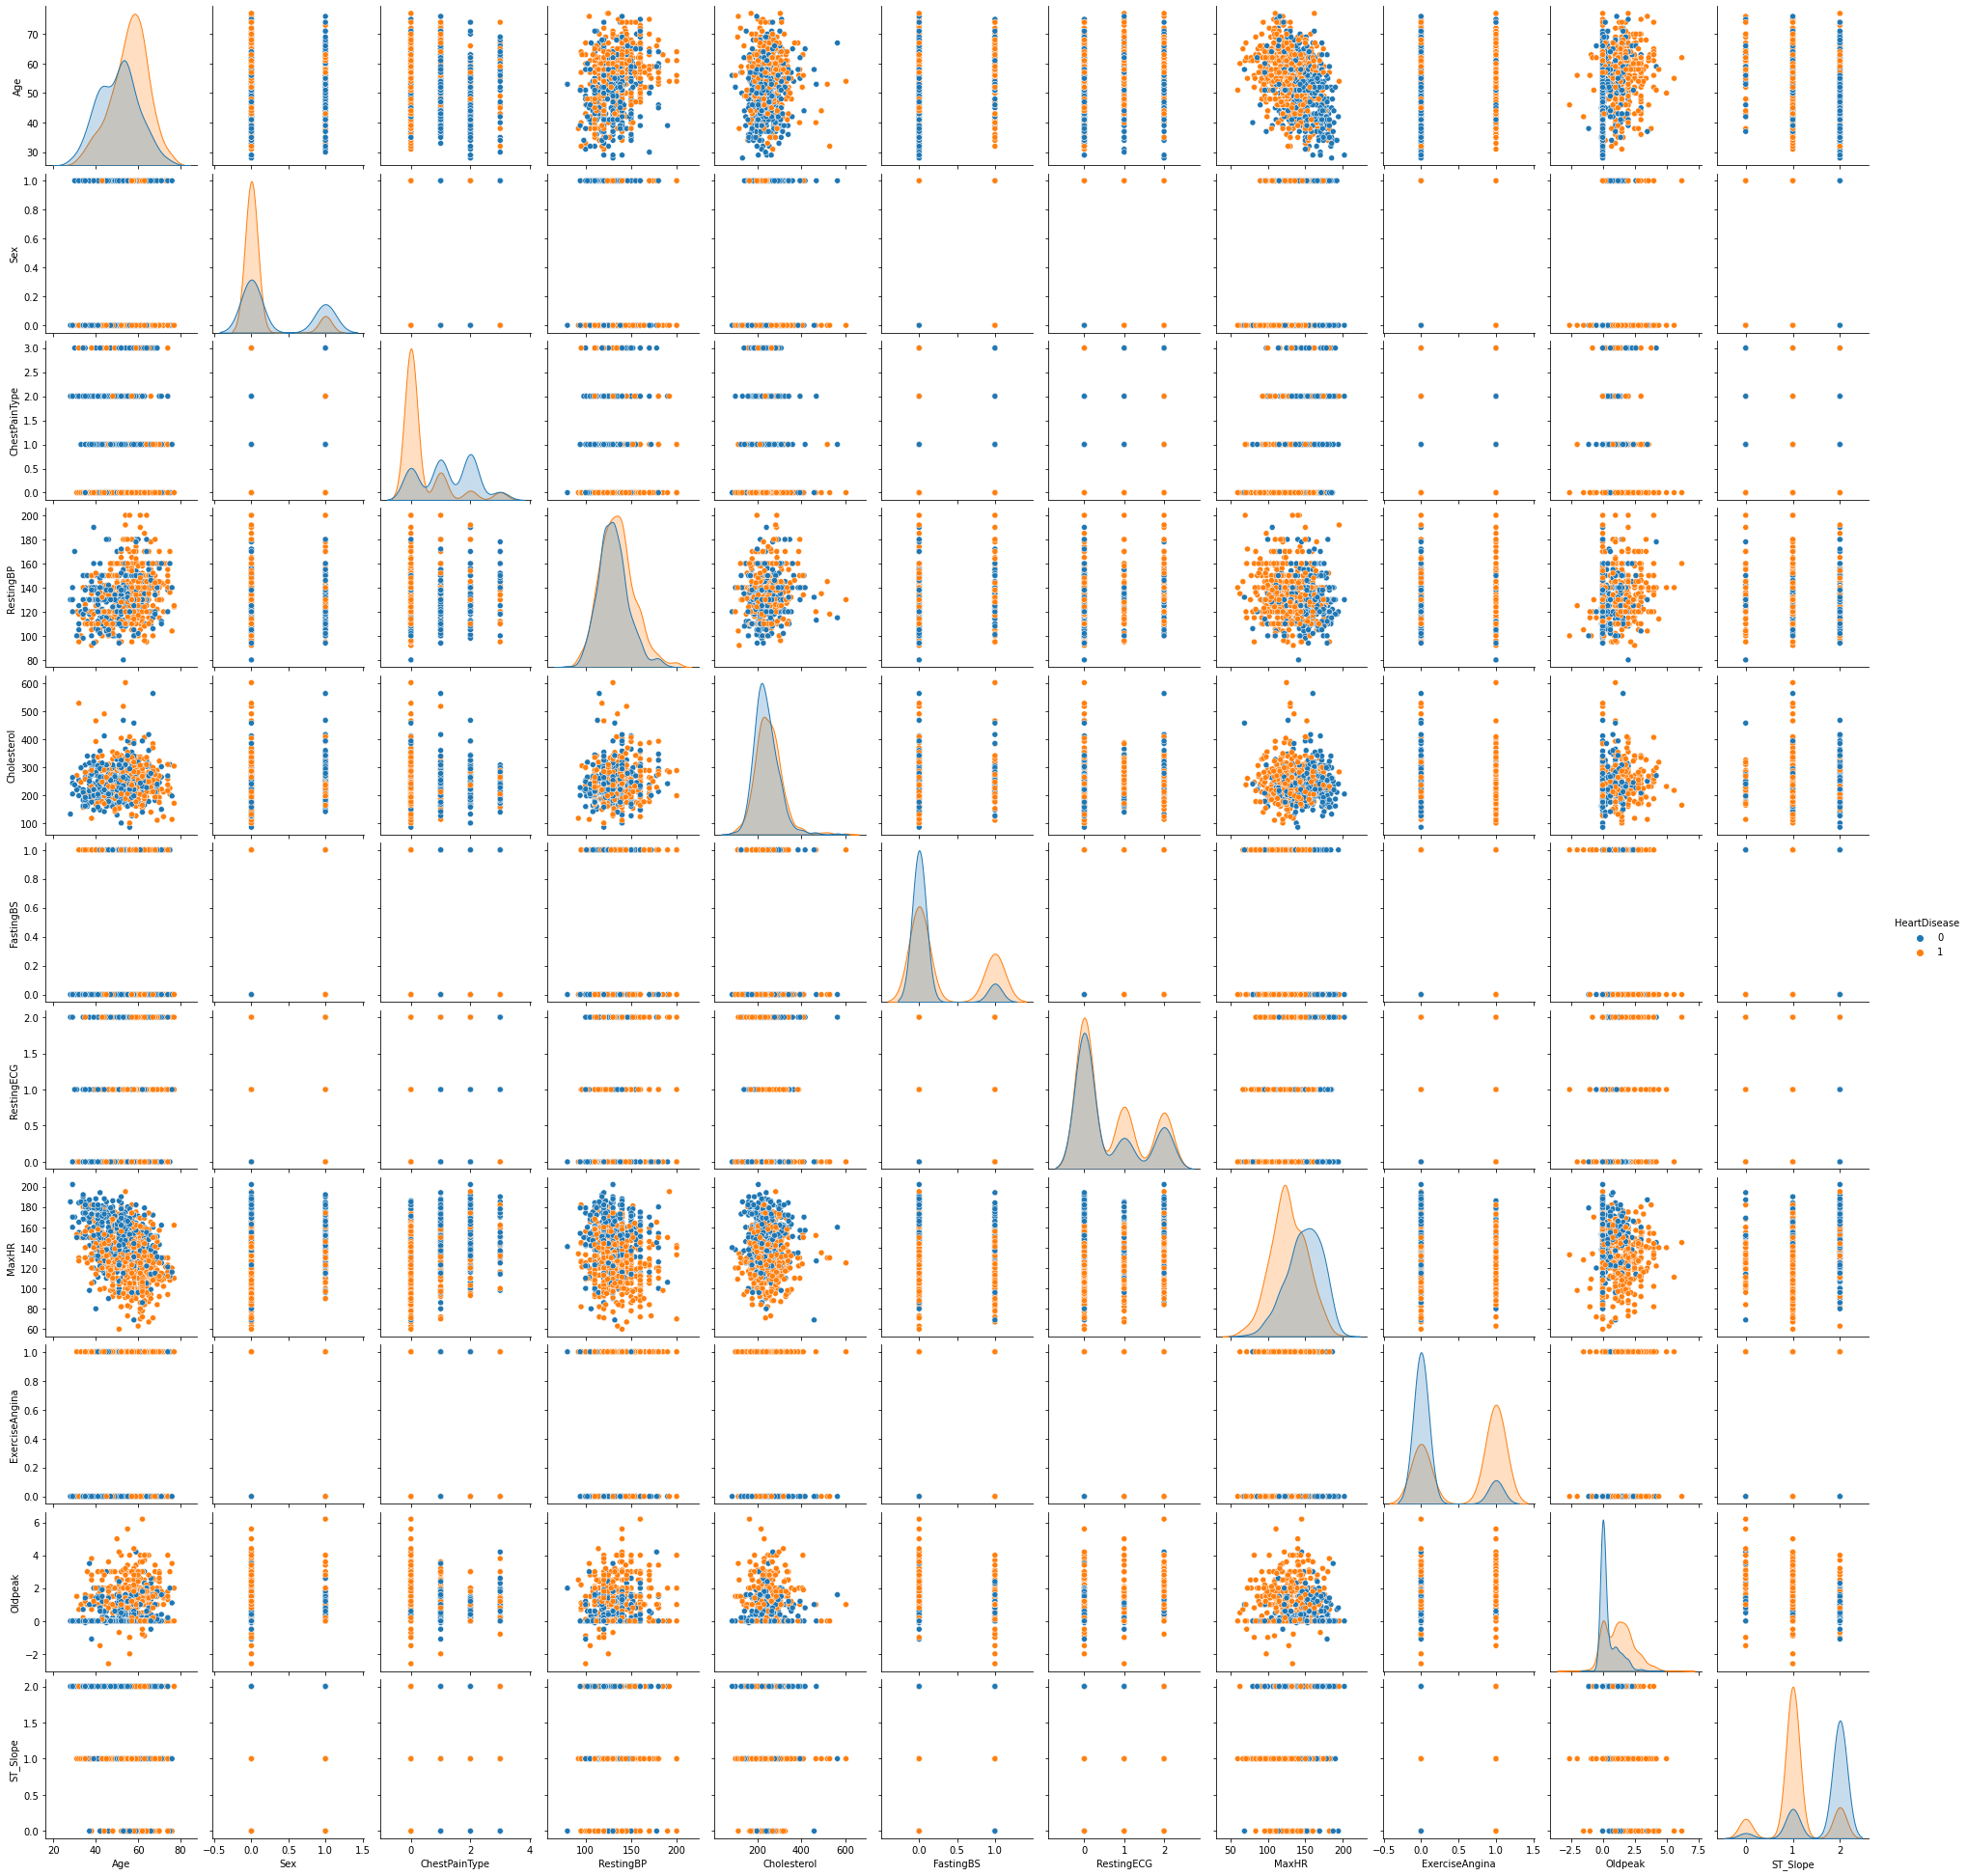

In [21]:
sns.pairplot(df_EDA, hue='HeartDisease')

### Numeric features

Now we want to see the correlation between each numerical features

<AxesSubplot:>

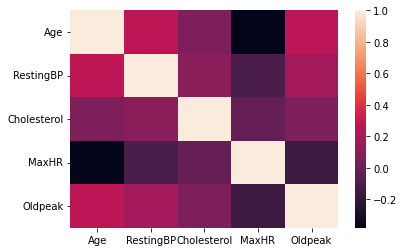

In [22]:
sns.heatmap(df_EDA[num_cols].corr())

As shown above, the correlation between each features are not high, so we don't have to worry about multicollinearity.

In [23]:
def num_plot(df, col):
    fig = px.histogram(df, x=col, color="HeartDisease",
                       marginal="box")
    fig.update_layout(height=400, width=500, showlegend=True)
    fig.update_traces(marker_line_width=1,marker_line_color="black")
    fig.show()

More detail about numerical features are shown below :

In [24]:
for col in num_cols:
    num_plot(df_EDA, col)

### Categorical Features

In [25]:
#chi test of cat_cols  
def chi_test(x, y):
    from scipy.stats import chi2_contingency
    """Pearson Chi-Square Independent Test: Measure the discrimination of features
    Params:
    -----------
    x: array-like, One-dimensional, discrete feature variable
    y: array-like，One-dimensional, the other discrete feature variable, 
       this test can measure the discrimination of features when y is target variable
    return:
    ----------
    chi_result: dict
        'Value': chi2 values,
        'Prob' : Probility, The smaller the value, the stronger the probility of rejecting the zero hypothesis
        'LLP' : -log(Prob), The larger the value, the stronger the probility of rejecting the zero hypothesis
        'DF' : degree of freedom.
    """
    tab = pd.crosstab(x, y).fillna(0)
    chi_value, p_value, def_free, expected = chi2_contingency(tab)
    return {'DF': def_free, 'Value': chi_value, 'Prob': p_value, 'LLP': -np.log(p_value)}

def get_random_index(n, x, random_state=RANDOM_SEED):
    """Range of index [0, n)
    n: range
    x: size
    
    return: range of index
    """
    np.random.seed(random_state)
    index = np.random.choice(np.arange(n), size=x, replace=False)
    return index

#get 100 rows sample randomly
index = get_random_index(len(df_EDA),100)

#zero hypothesis： independence x1 and x2 in cat_cols
chi_df_1 = pd.DataFrame(columns=['name1','name2','chi_value','chi_p','chi_DF','chi_LLP']) 
for i in range(0,len(cat_cols)): 
     
    chi_df = pd.DataFrame() 
    chi_df['name1'] = [list(cat_cols)[i]] 
    chi_df['name2'] = tar_col
    chi_result = chi_test(df_EDA[list(cat_cols)[i]][index].values.reshape(-1),
                        df_EDA[tar_col[0]][index].values.reshape(-1))
    chi_df['chi_value'] = [chi_result['Value']]
    chi_df['chi_p'] = [chi_result['Prob']]
    chi_df['chi_DF'] = [chi_result['DF']]
    chi_df['chi_LLP'] = [chi_result['LLP']]
    chi_df_1 = chi_df_1.append(chi_df)
        
chi_df_1.sort_values(by='chi_p')

name1         name2  chi_value         chi_p chi_DF    chi_LLP
0        ST_Slope  HeartDisease  35.988984  1.531410e-08      2  17.994492
0   ChestPainType  HeartDisease  32.254736  4.624851e-07      3  14.586651
0  ExerciseAngina  HeartDisease  15.593001  7.854479e-05      1   9.451841
0             Sex  HeartDisease   7.688718  5.556708e-03      1   5.192749
0       FastingBS  HeartDisease   4.966882  2.583719e-02      1   3.655941
0      RestingECG  HeartDisease   2.990942  2.241430e-01      2   1.495471

To see the relation between categorical features and heartdisease, 

we randomly choose 100 samples from dataset to have a Pearson Chi-Square Independent Test.

We can say `ST_Slope`, `ChestPainType` and `ExerciseAngina` are related to HeartDisease.

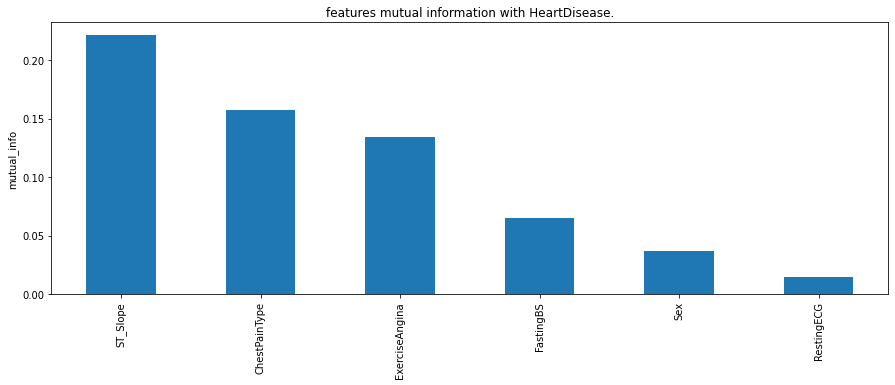

In [26]:
from sklearn.feature_selection import mutual_info_classif
#mutual information of features 
mutual = pd.Series(mutual_info_classif(df_EDA[cat_cols], df[tar_col[0]], random_state=RANDOM_SEED),
                   index=df_EDA[cat_cols].columns, name='mutual_info')
mutual.sort_values(ascending=False).plot.bar(figsize=(15,5))
plt.title('features mutual information with HeartDisease.')
plt.ylabel('mutual_info')
plt.show()

Here, we use features mutual information to enhance our conjecture.




# Preprocessing
-------------

## Encoding Categorical Features
We encode the categorical features same as we did in EDA.

In [27]:
# Encode nominal features
df['Sex'] = df['Sex'].replace({'M':0, 'F':1})
df['ExerciseAngina'] = df['ExerciseAngina'].replace({'Y':1, 'N':0})
# Encode ordinal features
df['ChestPainType'] = df['ChestPainType'].replace({'TA': 3, 'ATA': 2, 'NAP': 1, 'ASY': 0})
df['RestingECG'] = df['RestingECG'].replace({'Normal':0, 'ST':1, 'LVH':2})
df['ST_Slope'] = df['ST_Slope'].replace({'Down': 0, 'Flat': 1, 'Up':2})
df.head()

Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0   40    0              2        140        289.0          0           0   
1   49    1              1        160        180.0          0           0   
2   37    0              2        130        283.0          0           1   
3   48    1              0        138        214.0          0           0   
4   54    0              1        150        195.0          0           0   

   MaxHR  ExerciseAngina  Oldpeak  ST_Slope  HeartDisease  
0    172               0      0.0         2             0  
1    156               0      1.0         1             1  
2     98               0      0.0         2             0  
3    108               1      1.5         1             1  
4    122               0      0.0         2             0

## Splitting Data
First of all, we need to split our dataset before further preprocessing.


In [28]:
X, y = df.drop(['HeartDisease'], axis = 1), df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_SEED, test_size = 0.10, stratify=y)

In [29]:
print(f'X_train size: {X_train.shape}\nX_test size: {X_test.shape}\ny_train size: {y_train.shape}\ny_test size: {y_test.shape}\n')

X_train size: (825, 11)
X_test size: (92, 11)
y_train size: (825,)
y_test size: (92,)



## Missing Data Imputation
After splitting, we can now study how to imput missing values of `Cholesterol`.

We perform the imputation only on the training set to avoid any data leakage.

Here we choose `KNNImputer` as our imputer. 

It is an imputation for completing missing values using k-Nearest Neighbors.

In [32]:
import numpy as np
import os

imputer = KNNImputer()
X_train = imputer.fit_transform(X_train)
print(f'Null values in X_train: {np.isnan(X_train).sum()}')

# save the knn imputer model as pickle file
with open(os.path.join('Model','knnImputer.pkl'), 'wb+') as knnPickle:
    pickle.dump(imputer, knnPickle)

Null values in X_train: 0


Then we perform the transformation on the testing set as well.

In [33]:
X_test = imputer.transform(X_test)
print(f'Null values in X_test: {np.isnan(X_test).sum()}')

Null values in X_test: 0


## Feature Scaling

Standard mean/std scaler and min-max normalization are two common methods for feature scaling. 

However, there is a new technique called Gauss rank transformation.

It is believed that Gauss rank transformation has better performance in deep neural networks training.

Therefore, we want to give it a try.

In [34]:
import warnings
warnings.filterwarnings("ignore")
import time
import matplotlib.pyplot as plt
from scipy.special import erfinv
from pathlib import Path

class GaussRank():
    """
    CPU & GPU codes are mostly the same except for the imported libraries.
    GPU codes are executed automatically if the input tensor is on GPU.
    """
    def __init__(self,epsilon=0.001):
        self.epsilon = epsilon
        self.lower = -1 + self.epsilon
        self.upper = 1 - self.epsilon
        self.range = self.upper - self.lower

    def fit(self,x):
        self.fit_transform(x)
        return self    
        
    def fit_transform(self,x):
        # x is a 1D numpy/cupy array
        msg = 'input must be a 1D numpy/cucpy array'
        
        assert isinstance(x,np.ndarray) or isinstance(x,cp.ndarray),msg
        erfinv_ = erfinv if isinstance(x,np.ndarray) else cupy_erfinv
        DataFrame = pd.DataFrame if isinstance(x,np.ndarray) else gd.DataFrame
        
        j = x.argsort().argsort()

        assert (j.min() == 0).all()
        assert (j.max() == len(j) - 1).all()

        j_range = len(j) - 1
        self.divider = j_range / self.range

        transformed = j / self.divider
        transformed = transformed - self.upper
        transformed = erfinv_(transformed)
        
        transformed_map = DataFrame()
        transformed_map['src'] = x
        transformed_map['tgt'] = transformed
        transformed_map = transformed_map.sort_values(by='src',ascending=True)
        self.transformed_map = transformed_map
        return transformed
    
    def transform(self,x):
        return self._transform(x,src_col='src',tgt_col='tgt')
    
    def inverse_transform(self,transformed):
        return self._transform(transformed,src_col='tgt',tgt_col='src')
    
    def _transform(self,x,src_col,tgt_col):
        msg = 'input must be a 1D numpy/cucpy array'
        assert isinstance(x,np.ndarray) or isinstance(x,cp.ndarray),msg
        transformed_map = self.transformed_map
        N = len(transformed_map)
        pos = transformed_map[src_col].searchsorted(x, side='left')
        
        pos[pos>=N] = N-1
        pos[pos-1<=0] = 0

        x1 = transformed_map[src_col].values[pos]
        x2 = transformed_map[src_col].values[pos-1]
        y1 = transformed_map[tgt_col].values[pos]
        y2 = transformed_map[tgt_col].values[pos-1]

        relative = (x-x2)  / (x1-x2)
        return (1-relative)*y2 + relative*y1

### Gauss Rank Transformation on Numeric Features

In [35]:
X_train_scaled = X_train.copy()

for col in num_cols:
    scaler = GaussRank()
    X_train_scaled[:,list(df).index(col)] = scaler.fit_transform(X_train[:,list(df).index(col)])
    # save the scaler as pickle file    
    with open(os.path.join('Model',f'{col}Scaler.pkl'), 'wb+') as scalerPickle:
        pickle.dump(scaler, scalerPickle)

In [36]:
train_df = pd.DataFrame(X_train, columns=df.drop(['HeartDisease'], axis=1).columns)
scaled_train_df = pd.DataFrame(X_train_scaled, columns=df.drop(['HeartDisease'], axis=1).columns)

### MinMax Scaler on Categorical Features
Since nominal features are encoded in 0 and 1, there is no need for further operation.

We only need to scale ordinal features.

In [37]:
for col in ord_cols:
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(X_train[:,list(df).index(col)].reshape(-1,1))
    X_train_scaled[:,list(df).index(col)] = scaled.squeeze()
    # save the scaler as pickle file    
    with open(os.path.join('Model',f'{col}Scaler.pkl'), 'wb+') as scalerPickle:
        pickle.dump(scaler, scalerPickle)

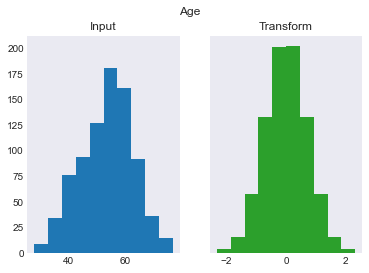

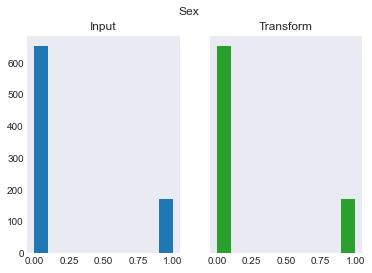

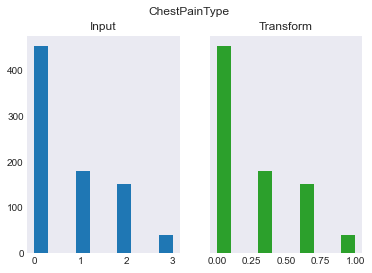

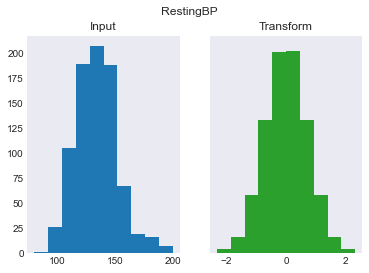

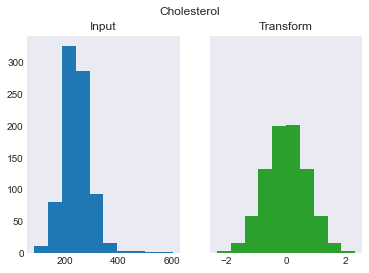

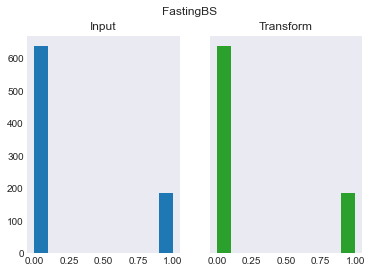

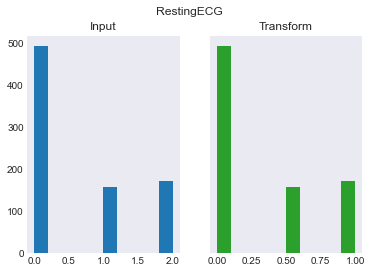

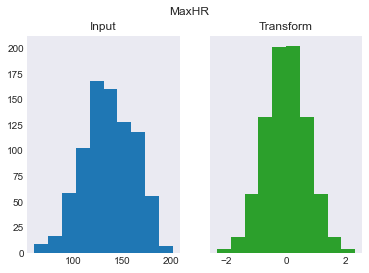

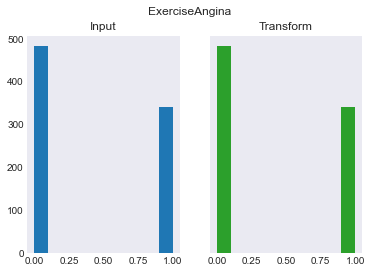

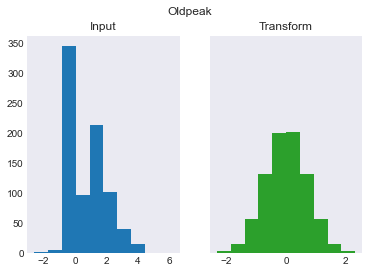

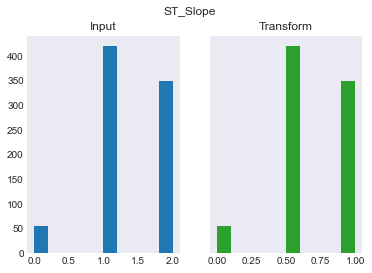

In [38]:
plt.style.use('seaborn-dark')
for col in train_df.columns:
    fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
    fig.suptitle(col)
    ax1.hist(train_df[col], color='C0')
    ax1.set_title('Input')
    ax2.hist(scaled_train_df[col], color='C2')
    ax2.set_title('Transform')
    

Scaling test data with saved scalers

In [39]:
for col in num_cols:
    with open(os.path.join('Model', f'{col}Scaler.pkl'), 'rb') as scalerPickle:
        scaler = pickle.load(scalerPickle)
        X_train[:,list(df).index(col)] = scaler.transform(X_train[:,list(df).index(col)])
        X_test[:,list(df).index(col)] = scaler.transform(X_test[:,list(df).index(col)])
for col in ord_cols:
    with open(os.path.join('Model', f'{col}Scaler.pkl'), 'rb') as scalerPickle:
        scaler = pickle.load(scalerPickle)
        X_train[:,list(df).index(col)] = scaler.transform(X_train[:,list(df).index(col)].reshape(-1,1)).squeeze()
        X_test[:,list(df).index(col)] = scaler.transform(X_test[:,list(df).index(col)].reshape(-1,1)).squeeze()

## Feature Selection

# Model Building
---------------------

In [40]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=RANDOM_SEED)

## Dataset

In [41]:
class Dataset(Dataset):
    def __init__(self, X_data, y_data, device=DEVICE):
        self.X_data = X_data
        self.y_data = y_data 
    
    def __len__ (self):
        return len(self.X_data)
    
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

train_data = Dataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train.values))
val_data = Dataset(torch.FloatTensor(X_valid), torch.FloatTensor(y_valid.values))
test_data = Dataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test.values))

In [42]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE)
valid_loader = DataLoader(dataset=val_data, batch_size=1)
test_loader = DataLoader(dataset=test_data, batch_size=1)

## Model

In [355]:
class LightNet(LightningModule):
    def __init__(self):
        super(LightNet, self).__init__()
        self.fc1 = nn.Linear(11, 11)
        self.fc2 = nn.Linear(11, 11)
        self.fc3 = nn.Linear(11, 11)
        self.fc4 = nn.Linear(11, 11)
        self.fc5 = nn.Linear(11, 4)
        self.layer_out = nn.Linear(4, 1) 
        
    def forward(self, x):
        xx = x
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x) + xx)
        xx = x
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x) + xx)
        x = F.relu(self.fc5(x))
        x = self.layer_out(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        y = y.unsqueeze(1)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        self.log("loss", loss)    
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.unsqueeze(1)
        y_hat = self.forward(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        self.log("val_loss", loss, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y = y.unsqueeze(1)
        y_hat = self.forward(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        self.log("test_loss", loss, on_epoch=True)
        

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=LR)

    def train_dataloader(self):
        return DataLoader(dataset=train_data, batch_size=BATCH_SIZE)

    def val_dataloader(self):
        return DataLoader(dataset=val_data, batch_size=1)

    def test_dataloader(self):
        return DataLoader(dataset=test_data, batch_size=1)

# Model Training
-----------------

In [356]:
light_model = LightNet()
early_stop_callback = EarlyStopping(monitor='val_loss', patience=5)
trainer = Trainer(gpus=1, callbacks=[early_stop_callback], log_every_n_steps=20)   
trainer.fit(light_model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type   | Params
-------------------------------------
0 | fc1       | Linear | 132   
1 | fc2       | Linear | 132   
2 | fc3       | Linear | 132   
3 | fc4       | Linear | 132   
4 | fc5       | Linear | 48    
5 | layer_out | Linear | 5     
-------------------------------------
581       Trainable params
0         Non-trainable params
581       Total params
0.002     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

# Model Testing 
-----------------

In [357]:
trainer.test()

Restoring states from the checkpoint path at C:\Users\barry\Desktop\Pytorch\ai\lightning_logs\version_49\checkpoints\epoch=31-step=1343.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at C:\Users\barry\Desktop\Pytorch\ai\lightning_logs\version_49\checkpoints\epoch=31-step=1343.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.37694454193115234}
--------------------------------------------------------------------------------


[{'test_loss': 0.37694454193115234}]

In [358]:
y_pred_prob_list = []
prediction_list = []

for batch_idx, (X_test_batch, y_test_batch) in enumerate(test_loader):
    output = light_model(X_test_batch)
    y_pred_prob = torch.sigmoid(output)
    y_pred_prob_list.append(y_pred_prob)
    y_pred = torch.round(y_pred_prob)
    prediction_list.append(y_pred)

In [359]:
y_pred_prob_list = [a.squeeze().tolist() for a in y_pred_prob_list]
preds = [a.squeeze().tolist() for a in prediction_list]

In [360]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.88      0.85      0.86        41
           1       0.88      0.90      0.89        51

    accuracy                           0.88        92
   macro avg       0.88      0.88      0.88        92
weighted avg       0.88      0.88      0.88        92



In [361]:
def get_scores(y, y_pred):
    data={'Accuracy': np.round(accuracy_score(y, y_pred),2),
    'Precision':np.round(precision_score(y, y_pred),2),
    'Recall':np.round(recall_score(y, y_pred),2),
    'F1':np.round(f1_score(y, y_pred),2),
    'ROC AUC':np.round(roc_auc_score(y, y_pred),2)}
    scores_df = pd.Series(data).to_frame('scores')
    return scores_df

def conf_matrix(y, y_pred):
    fig, ax =plt.subplots(figsize=(3.5,3.5))
    labels=['No','Yes']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title('Heart Failure?', fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test')
    ax.set_xlabel('Predicted')

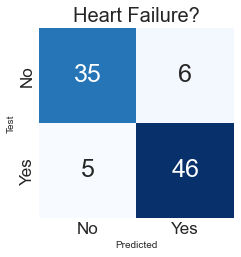

In [362]:
conf_matrix(y_test, preds)

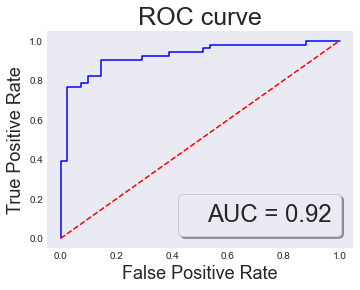

In [363]:
plt.figure(figsize = (5.5, 4))

fpr, tpr, _ = roc_curve(y_test, y_pred_prob_list)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve',fontsize=25)
plt.ylabel('True Positive Rate',fontsize=18)
plt.xlabel('False Positive Rate',fontsize=18)
plt.legend(loc = 'lower right', fontsize=24, fancybox=True, shadow=True, frameon=True, handlelength=0)
plt.show()

In [364]:
get_scores(y_test,preds)

scores
Accuracy     0.88
Precision    0.88
Recall       0.90
F1           0.89
ROC AUC      0.88

# Comparison Among Different Methods
------------
1. Logistic Regression
2. Random Forest
3. SVM
4. KNN
5. Ada Boost

## 1. Logistic Regression

              precision    recall  f1-score   support

           0       0.82      0.88      0.85        41
           1       0.90      0.84      0.87        51

    accuracy                           0.86        92
   macro avg       0.86      0.86      0.86        92
weighted avg       0.86      0.86      0.86        92



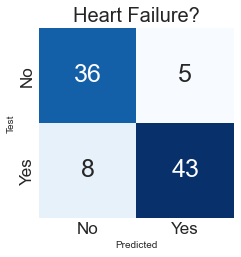

In [370]:
from sklearn.linear_model import LogisticRegression

LR_model = LogisticRegression()
LR_model.fit(X_train, y_train)

LR_preds = LR_model.predict(X_test)

conf_matrix(y_test, LR_preds)
print(classification_report(y_test, LR_preds))

In [378]:
get_scores(y_test, LR_preds)

scores
Accuracy     0.86
Precision    0.90
Recall       0.84
F1           0.87
ROC AUC      0.86

## 2. Random Forest

In [400]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

test_error_rate=[]
for k in range(1, 100):
    RF_model = RandomForestClassifier(n_estimators=k)
    RF_model.fit(X_train,y_train)
    RF_preds = RF_model.predict(X_test)
    test_error = 1-accuracy_score(y_test, RF_preds)
    test_error_rate.append(test_error)

Text(0, 0.5, 'Error')

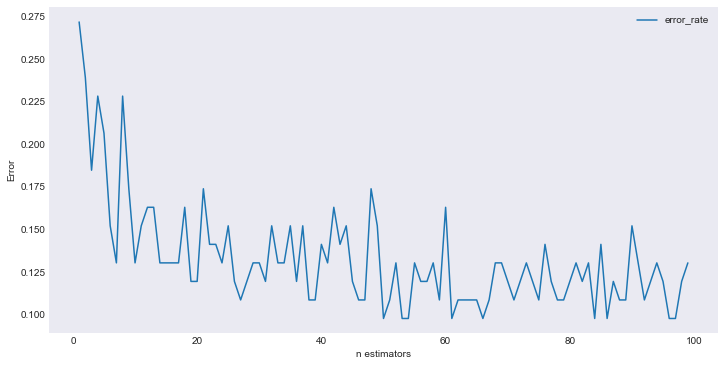

In [401]:
plt.figure(figsize = (12,6))
plt.plot(range(1, 100),test_error_rate,label='error_rate')
plt.legend()
plt.xlabel('n estimators')
plt.ylabel('Error')

In [402]:
minimum = min(test_error_rate)
print(minimum)
test_error_rate.index(minimum)

0.09782608695652173


49

              precision    recall  f1-score   support

           0       0.80      0.90      0.85        41
           1       0.91      0.82      0.87        51

    accuracy                           0.86        92
   macro avg       0.86      0.86      0.86        92
weighted avg       0.86      0.86      0.86        92



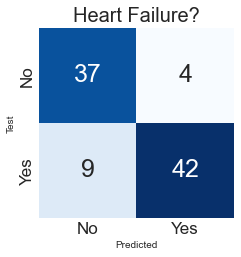

In [403]:
RF_model = RandomForestClassifier(n_estimators = 49)
RF_model.fit(X_train, y_train)

RF_preds = RF_model.predict(X_test)

conf_matrix(y_test, RF_preds)
print(classification_report(y_test, RF_preds))

In [404]:
get_scores(y_test, RF_preds)

scores
Accuracy     0.86
Precision    0.91
Recall       0.82
F1           0.87
ROC AUC      0.86

## 3. SVM

              precision    recall  f1-score   support

           0       0.84      0.90      0.87        41
           1       0.92      0.86      0.89        51

    accuracy                           0.88        92
   macro avg       0.88      0.88      0.88        92
weighted avg       0.88      0.88      0.88        92



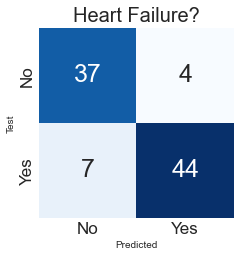

In [374]:
from sklearn.svm import SVC

SVM_model = SVC()
SVM_model.fit(X_train, y_train)

SVM_preds = SVM_model.predict(X_test)

conf_matrix(y_test, SVM_preds)
print(classification_report(y_test, SVM_preds))

In [380]:
get_scores(y_test, SVM_preds)

scores
Accuracy     0.88
Precision    0.92
Recall       0.86
F1           0.89
ROC AUC      0.88

## 4. KNN

In [375]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

test_error_rate=[]
for k in range(1, 30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train,y_train)
    knn_preds = knn_model.predict(X_test)
    test_error = 1 - accuracy_score(y_test, knn_preds)
    test_error_rate.append(test_error)

Text(0, 0.5, 'Error')

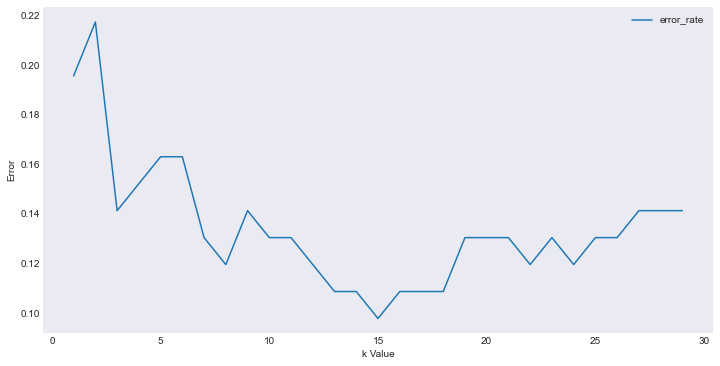

In [376]:
plt.figure(figsize = (12,6))
plt.plot(range(1,30),test_error_rate,label='error_rate')
plt.legend()
plt.xlabel('k Value')
plt.ylabel('Error')

found the best k value is 15

              precision    recall  f1-score   support

           0       0.85      0.95      0.90        41
           1       0.96      0.86      0.91        51

    accuracy                           0.90        92
   macro avg       0.90      0.91      0.90        92
weighted avg       0.91      0.90      0.90        92



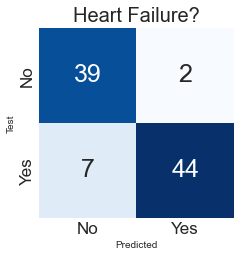

In [377]:
knn_model = KNeighborsClassifier(n_neighbors=15)
knn_model.fit(X_train,y_train)

knn_preds = knn_model.predict(X_test)

conf_matrix(y_test, knn_preds)
print(classification_report(y_test, knn_preds))

In [381]:
get_scores(y_test, knn_preds)

scores
Accuracy     0.90
Precision    0.96
Recall       0.86
F1           0.91
ROC AUC      0.91

## 5. Ada Boost

In [393]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

test_error_rate=[]
for k in range(1, 100):
    AB_model = AdaBoostClassifier(n_estimators=k)
    AB_model.fit(X_train,y_train)
    AB_preds = AB_model.predict(X_test)
    test_error = 1-accuracy_score(y_test, AB_preds)
    test_error_rate.append(test_error)

Text(0, 0.5, 'Error')

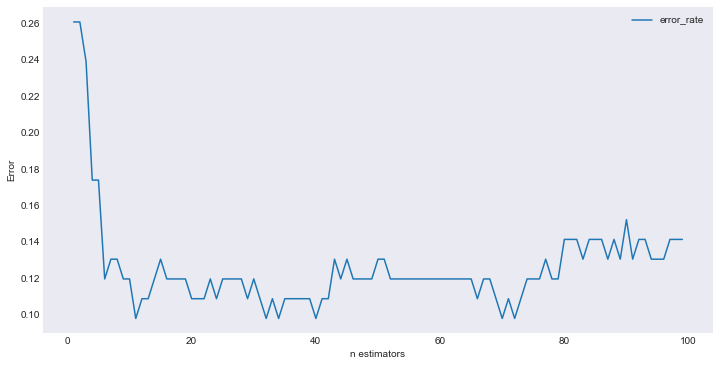

In [394]:
plt.figure(figsize = (12,6))
plt.plot(range(1, 100),test_error_rate,label='error_rate')
plt.legend()
plt.xlabel('n estimators')
plt.ylabel('Error')

In [398]:
minimum = min(test_error_rate)
print(minimum)
test_error_rate.index(minimum)

0.09782608695652173


10

              precision    recall  f1-score   support

           0       0.83      0.93      0.87        41
           1       0.93      0.84      0.89        51

    accuracy                           0.88        92
   macro avg       0.88      0.88      0.88        92
weighted avg       0.89      0.88      0.88        92



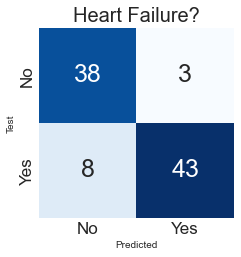

In [399]:
AB_model = AdaBoostClassifier(n_estimators=10)
AB_model.fit(X_train,y_train)

AB_preds = AB_model.predict(X_test)

conf_matrix(y_test, AB_preds)
print(classification_report(y_test, AB_preds))

In [405]:
get_scores(y_test, AB_preds)

scores
Accuracy     0.88
Precision    0.93
Recall       0.84
F1           0.89
ROC AUC      0.88